In [1]:
"""
Patrick Brosseau 2023/03/20
"""

import numpy as np
from numpy import mean
from numpy import std
from numpy.random import random, seed
from scipy.interpolate import UnivariateSpline
from scipy import interpolate
from scipy.ndimage import gaussian_filter,gaussian_filter1d
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold, train_test_split
import tensorflow as tf

from tqdm import tqdm
import time
import glob

# Load data

Text(0, 0.5, 'Energy (eV)')

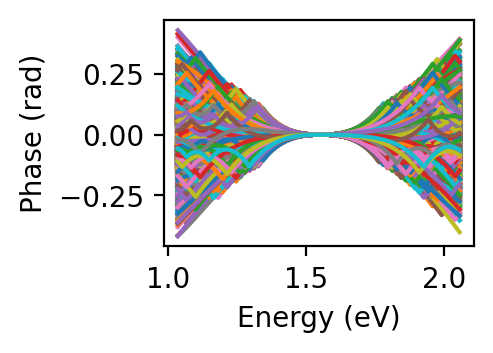

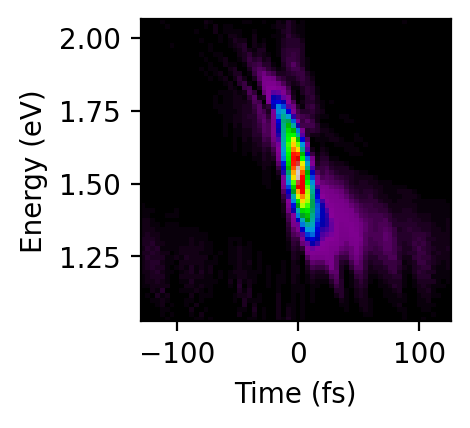

In [16]:
# np.savez("training_data.npz",training_full_set=training_full_set,label_full_set=label_full_set)
files = ["training_data1.npz","training_data2.npz"]
training_full_set = []
label_full_set = []
for file in files:
    dat = np.load(file)
    training_full_set.append(dat['training_set'])
    label_full_set.append(dat['label_set'])
    block_size = dat['training_set'].shape
training_full_set = np.reshape(np.array(training_full_set),[block_size[0]*len(files),block_size[1],block_size[2]])
label_full_set = np.reshape(np.array(label_full_set),[block_size[0]*len(files),block_size[1]])

ev = dat['ev']
t = dat['time']*1e15

plt.figure(figsize=(4/2,3/2),dpi=200)
plt.plot(ev,label_full_set.T)
plt.xlabel("Energy (eV)")
plt.ylabel("Phase (rad)")

plt.figure(figsize=(2,2),dpi=200)
plt.pcolormesh(t,ev,training_full_set[0], cmap="nipy_spectral")
plt.xlabel("Time (fs)")
plt.ylabel("Energy (eV)")

# Generate and train model

In [3]:
# Model
# number of input nodes = 2*len(spectrum)
# single hidden layer with 100 nodes
# number of output nodes = len(spectrum)
def get_model(n_inputs, n_outputs):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(64, 1, activation='relu', input_shape=(64, 64, 1)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, 1, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(32, 1, activation='relu'))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(64))
    
    model.compile(loss='mse', optimizer='adam',metrics="accuracy")
    return model

#Shuffle and split training_full_set into 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(training_full_set, label_full_set, test_size=0.2, random_state=42)
n_inputs, n_outputs = X_train.shape[1], y_train.shape[1]
print(n_inputs)
print(n_outputs)
model = get_model(n_inputs, n_outputs)

64
64


In [4]:
# fit the model on all data

# get the start time
st = time.time()
stp = time.process_time()

history = model.fit(X_train, y_train, verbose=2, epochs=10)

# get the end time
etp = time.process_time()
et = time.time()

Epoch 1/10
125/125 - 15s - loss: 0.0020 - accuracy: 0.0355 - 15s/epoch - 120ms/step
Epoch 2/10
125/125 - 13s - loss: 8.9430e-04 - accuracy: 0.0733 - 13s/epoch - 102ms/step
Epoch 3/10
125/125 - 13s - loss: 7.0900e-04 - accuracy: 0.0868 - 13s/epoch - 107ms/step
Epoch 4/10
125/125 - 14s - loss: 6.0858e-04 - accuracy: 0.1135 - 14s/epoch - 109ms/step
Epoch 5/10
125/125 - 16s - loss: 5.3453e-04 - accuracy: 0.1385 - 16s/epoch - 124ms/step
Epoch 6/10
125/125 - 14s - loss: 4.8684e-04 - accuracy: 0.1377 - 14s/epoch - 112ms/step
Epoch 7/10
125/125 - 15s - loss: 4.5724e-04 - accuracy: 0.1515 - 15s/epoch - 117ms/step
Epoch 8/10
125/125 - 14s - loss: 4.2276e-04 - accuracy: 0.1700 - 14s/epoch - 113ms/step
Epoch 9/10
125/125 - 15s - loss: 4.1697e-04 - accuracy: 0.1608 - 15s/epoch - 121ms/step
Epoch 10/10
125/125 - 15s - loss: 3.8100e-04 - accuracy: 0.1870 - 15s/epoch - 119ms/step


In [5]:
# get execution time
res = etp - stp
print('CPU Execution time:', res, 'seconds')
res = et - st
print('Wall time:', res, 'seconds')

CPU Execution time: 423.359375 seconds
Wall time: 143.29706931114197 seconds


# Verify Model Convergence

32/32 [==============================] - 1s 34ms/step - loss: 3.8736e-04 - accuracy: 0.2780

Test accuracy: 0.27799999713897705


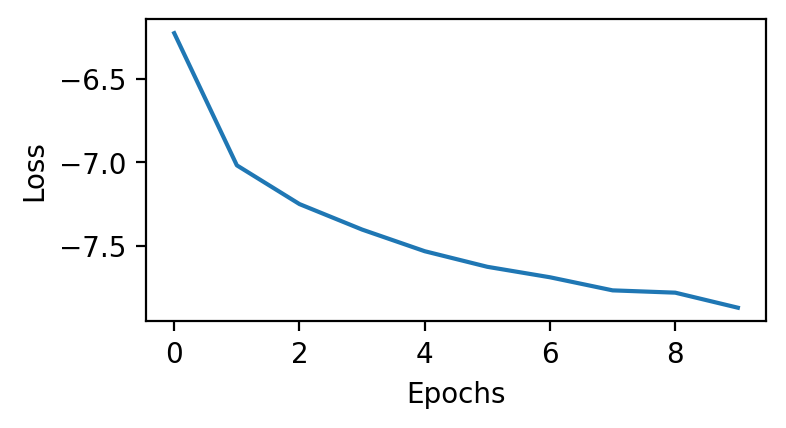

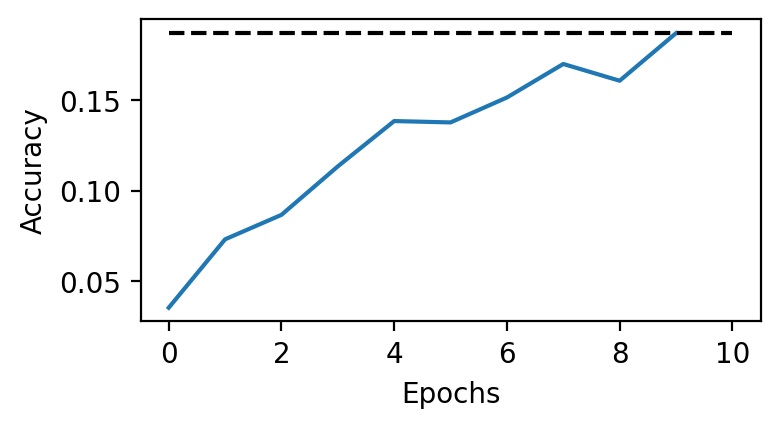

In [6]:
plt.figure(figsize=(4,2),dpi=200)
plt.plot(np.log(history.history['loss']))
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.hlines(history.history['loss'][-1],0,len(history.history['loss']),color="k",linestyle="--")

plt.figure(figsize=(4,2),dpi=200)
plt.plot(history.history['accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.hlines(history.history['accuracy'][-1],0,len(history.history['accuracy']),color="k",linestyle="--")

score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest accuracy:', score[1])

# Validate Model

(1000, 64, 64)
1/1 [==============================] - 0s 183ms/step


Text(0, 0.5, 'Amplitude (a.u.)')

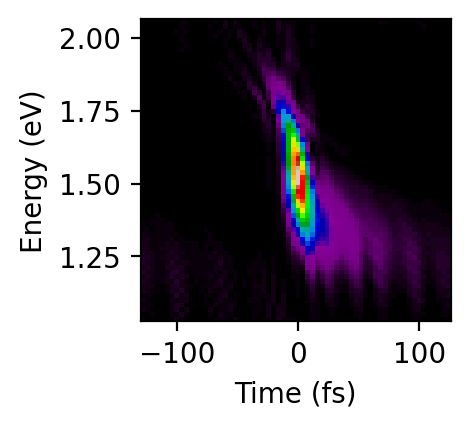

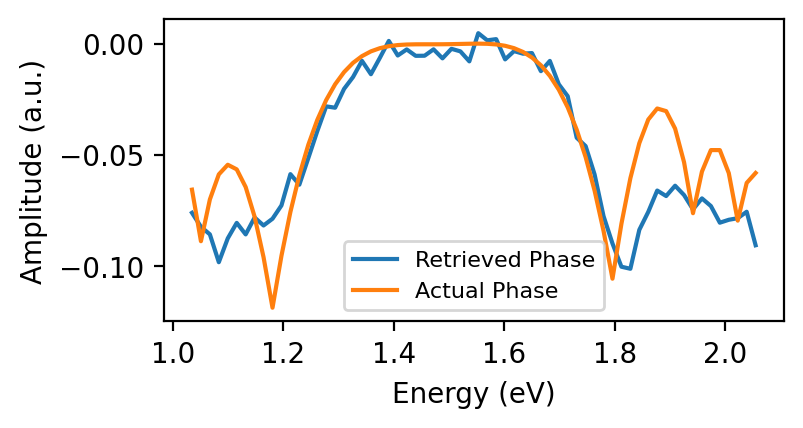

In [7]:
"""
Validate model with test data from earlier partition

1) Take test spectrum
2) Couple with ideal goal spectrum
3) Use model to predict the amplitude mask that would shape the test spectrum into the goal spectrum
4) Compare predicted mask to ideal mask
"""
print(X_test.shape)
test_ind = 704
test_FROG= X_test[test_ind,:,:] #get just the input spectrum for the test partition

row = test_FROG
newX = np.asarray([row])
newX = tf.convert_to_tensor(newX)
yhat = model.predict(newX)
# print('Predicted: %s' % yhat[0])

plt.figure(figsize=(2,2),dpi=200)
plt.pcolormesh(t,ev,test_FROG, cmap="nipy_spectral")
plt.xlabel("Time (fs)")
plt.ylabel("Energy (eV)")

plt.figure(figsize=(4,2),dpi=200)
plt.plot(ev,yhat[0][0:64],label="Retrieved Phase")
plt.plot(ev,y_test[test_ind][0:64],label="Actual Phase")
plt.legend(fontsize=8)
plt.xlabel("Energy (eV)")
plt.ylabel("Amplitude (a.u.)")